# Skeletonization using Fuzzy Logic

## Introduction
This demo shows how our skeletonization scheme works using fuzzy logic for pruning. For more information please read our papers. If you use this code or part of it for your research please respectfully cite these publications:

[1] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2017. Skeleton Matching with Applications in Severe Weather Detection, Applied Soft Computing. [Link1](http://www.sciencedirect.com/science/article/pii/S1568494617303009) [Link2](https://pdfs.semanticscholar.org/a90c/ffa078ed566a1cb046ec68fd7195f01c7a76.pdf)

[2] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2016, December. Shape matching using skeleton context for automated bow echo detection. In Big Data (Big Data), 2016 IEEE International Conference on (pp. 901-908). IEEE. [Link1](http://ieeexplore.ieee.org/abstract/document/7840685/) [Link2](https://pdfs.semanticscholar.org/ae62/d5802980859ead8288f6ff436754253882d6.pdf) 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from fuzzyTransform import fuzzyTransform
from skeleton2Graph import *
import scipy.ndimage.morphology as morph
from skimage.morphology import thin
import matplotlib.patches

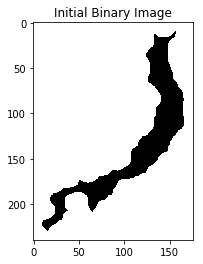

In [2]:
BW = mat2gray(cv2.imread('BW.png', cv2.IMREAD_GRAYSCALE).astype('float64'))
plt.imshow(BW,cmap='gray')
plt.title('Initial Binary Image')
plt.show()

### Skeletonization
Skeleton of a shape is a low-level representation that can be used for matching and recognition purposes in various fields of study including image retrieval and shape matching or human pose estimation and recovery. Skeleton can provide a good abstraction of a shape, which contains topological structure and its features. Because it is the simplest representation of a shape, there has been an extensive effort among researchers to develop generic algorithms for skeletonization of shapes. However, since there is no “true” skeleton defined for an object, the literature in skeletonization lack of a robust evaluation. The vast majority of the algorithms are based on Blum’s “Grassfire” analogy and formulation for skeletonization. The most important key factor in skeletonization algorithms is to preserve the topology of the shape. One of the most widely used algorithms is based on measuring the net outward flux by using Euclidean Distance Transform (EDT) of the binary image followed by a topology preserving thinning algorithm. We calculate the net outward flux per unit area and detect the location of the pixels where conservation of energy principle is violated. EDT maps a binary image into a gray level image with value of each pixel represents its euclidean distance to the border of image. Given Euclidean distance of an image ($D_E$), we should first compute the gradient vector field ($\nabla D_E$), and then the divergence of this vector field [19]. Mathematically, the divergence of the gradient vector field ($\nabla .
(\nabla D_E)$) is defined as the limit of the net outward flow of the field across the boundary of the area around the given point, while the area is shrinking to zero:

\begin{equation*}
\nabla \cdot (\nabla D_E) = \displaystyle{\lim_{S \to 0}} \iint_{C}\frac{\nabla D_E\cdot \vec{n}}{S} dC\;
\end{equation*}

where $C$ is the boundary, $S$ is the area, and $\vec{n}$ is the normal vector of the boundary. Hence, we can calculate net outward flux at each point $P = (x, y)$ as follow:

\begin{equation}
Flux(P) = \sum_{i=1}^{8}\nabla D_E(Q_i) \cdot \vec{n}\;, 
\end{equation}

where $Q_i$'s are neighbor points to point $P$. According to the direction of the normal vector, we can determine that positive or negative flux values are representing drain or source of energy, where energy-draining points are internal skeletal points, and energy-generating points are external skeletal points. In the following cell we calculate the EDT of the binary image and its gradient.

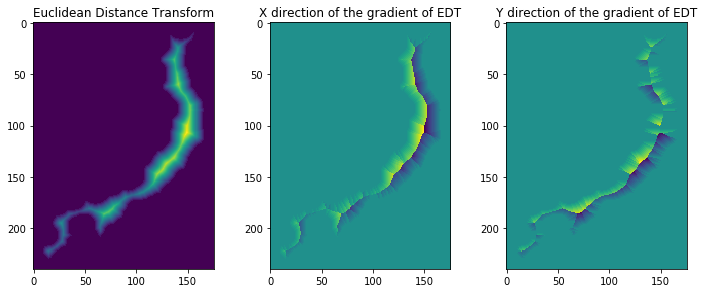

In [3]:
BW = 1 - BW
M,N = BW.shape

'''Calculating Euclidean Distance of the Binary Image'''
D,IDX = morph.distance_transform_edt(BW,return_distances=True, return_indices=True)
D = mat2gray(D)
X,Y = np.meshgrid(range(N),range(M))
delD_x = -(IDX[1,:,:] - X)
delD_y = -(IDX[0,:,:] - Y)
# normalize the derivatives
delD_norm = np.sqrt(pow(delD_x,2) + pow(delD_y,2))
with np.errstate(divide='ignore',invalid='ignore'):
    delD_xn   = delD_x / delD_norm
    delD_yn   = delD_y / delD_norm

mir_delD_xn  = mirrorBW(delD_xn)
mir_delD_yn  = mirrorBW(delD_yn)

f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10,30))
ax1.imshow(D)
ax1.set_title('Euclidean Distance Transform')
ax2.imshow(delD_x)
ax2.set_title('X direction of the gradient of EDT')
ax3.imshow(delD_y)
ax3.set_title('Y direction of the gradient of EDT')
plt.tight_layout()
plt.show()

### Flux Map
Now using the formula introduced above, we can caculate the flux map of the image.

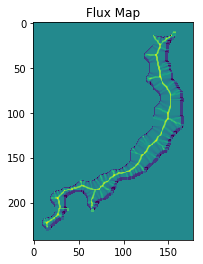

In [4]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
plt.imshow(np.nan_to_num(fluxMap))
plt.title('Flux Map')
plt.show()


By setting a threshold on flux values, initial binary skeleton map can be computed. Because we are dealing with highly boundary-variant shapes, the skeleton map would contain a large number of unwanted branches that make the subsequent matching steps complicated. We need to develop an automated method to remove all such branches while keeping the main skeleton intact. We introduce a new method to prune the skeleton using fuzzy logic, which will be developed in the next cell.

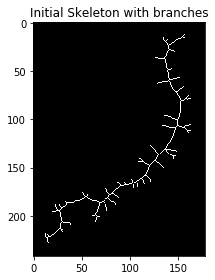

In [5]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
# Calculate flux threshold
fluxBWThreshold = (np.nanmax(fluxMap) - np.nanmean(fluxMap)) * 0.15 + np.nanmean(fluxMap)
with np.errstate(divide='ignore',invalid='ignore'):
    fluxThin = thin(fluxMap>fluxBWThreshold)

fluxLabeled,b = ndimage.label(fluxThin, np.array([[1,1,1], [1,1,1], [1,1,1]]))
labels ,pixelSize = np.unique(fluxLabeled,return_counts=True)
# Excluding the background
pixelSize = pixelSize[labels != 0]
labels = labels[labels != 0]
# Calculating the size threshold and filter out small objects
th = min(np.mean(pixelSize) + 3 * np.std(pixelSize), np.max(pixelSize))
selectedObjects = labels[np.where(pixelSize >= th)]

fluxTemp = np.zeros(fluxMap.shape)
fluxTemp[fluxLabeled == 1] = 1
plt.imshow(fluxTemp,cmap='gray')
plt.title('Initial Skeleton with branches')
plt.tight_layout()
plt.show()

### Fuzzy logic skeleton pruning
Our pruning algorithm needs to have the complete graph information of the skeleton including its vertices and edges' pixels coordinates. Therefore, the skeleton map is converted to a graph before the pruning step. Converting a skeleton map to a graph consists of two steps, namely extracting vertices and then points of each edge. We will go through each step as follow:

1. **Extracting Vertices**: For finding the vertices of the skeleton graph we need to scan the whole pixels of the image and based on the structure of other pixels around each pixel, we could decide weather it is a vertex or not. In this regard, we extract a $3\times3$ matrix around each pixel, which consists of its 8-connected neighbors. Then, in this matrix we build a local graph having pixels with value of 1 as its vertices. The connectivity of this graph is 4-connected neighbors, which means that 2 vertices are connected if and only if they are in one of the 4 main directions of each other (left, right, up, down). After that, in this graph we could calculate the Euler characteristic using its number of vertices and edges. If the Euler characteristic of the graph is greater than 2, it shows that this point is on the crossing of three or more edges, hence, it is a vertex with a branch type. If it is 1, it means that this point is an end point vertex of an edge. When it equals 2, the point is a simple edge point and not a vertex. Vertices extracted in this way for the skeleton is are depicted in output of the cell below (with a magnified part for a better representation). Red points in the image are branch points, and green ones are end points.
2. **Extracting Edge Points**: After finding vertices in the graph, we should form the edge list of the graph. We start with a random end point and traverse its neighbors to reach to a branch point or other endpoints. If the neighbor pixel is not a branch point nor an endpoint, it would be added to the current edge's pixel list. When we reach a branch point, we should add another edge to the edge list, having that branch point as its first point, and start searching edge points for the next edge in the edge list. If we reach an end point, we just start searching edge points for the next edge in the edge list. This approach will be continued until there is no edge left unprocessed. The result of finding edge points is also depicted in the output of the cell below.


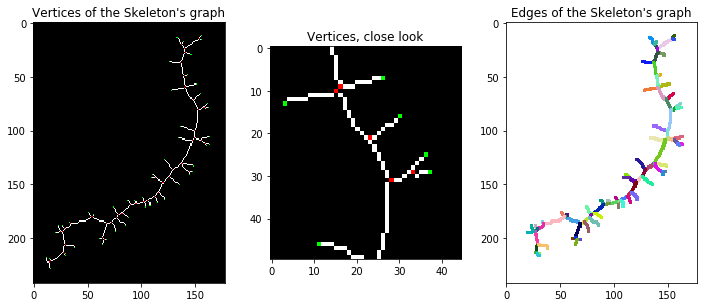

In [6]:
skeletonNew = np.zeros(fluxMap.shape)
adjacencyMatrix, edgeList, edgeProperties,edgeProperties2, verticesProperties, verticesProperties2, endPoints, branchPoints = skeleton2Graph(fluxTemp,fluxTemp*fluxMap)
vertices = np.concatenate((endPoints, branchPoints))
_,_,_, skeletonGraphPointsImg = findBranchPoints(fluxTemp,return_image=True)
f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10,30))
ax1.imshow(skeletonGraphPointsImg)
ax1.set_title('Vertices of the Skeleton\'s graph')
ax2.imshow(skeletonGraphPointsImg[50:100,125:170])
ax2.set_title('Vertices, close look')
ax3.imshow(graphDrawing(fluxTemp,edgeList,0.08))
ax3.set_title('Edges of the Skeleton\'s graph')

plt.tight_layout()
plt.show()

Having high sensitivity to border variations, almost all algorithms for skeletonization need to be followed by a pruning stage in order to remove thin branches caused by boundary deformations. These branches may significantly change the skeleton graph, and hence they should be treated carefully for the matter of topology preserving in skeletonization algorithms. Most of these algorithms use Boolean logic in their decision to remove or keep the branches. The output of these algorithms is a crisp value attributed to each edge distinguishing branch edges from main skeleton edges. However, if we ask a person to do pruning on a skeleton graph, he or she would extract the main skeleton with an uncertainty to some extent. On the other hand, fuzzy logic introduces many-valued logic in close proximity to human decision making system. Hence, we propose an approach based on fuzzy inference system to prune skeleton graph and extract the main skeleton.

In our method, we use the outward flux values of the pixels as an input to the fuzzy inference system. Heuristically from raw images of flux values, the higher the value of the outward flux in each pixel, the more probable that the pixel is in the main skeleton. Therefore, based on this observation we can extract a feature for every edge connected to a vertex in the skeleton graph. In order to record vertices properties in the flux images, we form an array, called $\Gamma$, for each vertex with the length of the number of the edges linked to it. The value attributed to each edge $e_j$ connected to the vertex $V_i$ could be computed as follow:
\begin{equation}
\Gamma\{V_i,e_j\} =\frac{1}{M_j-1} \sum_{P_j = 2}^{M_j}(W_G(P_j)\cdot Flux(P_j))\;,
\end{equation}
in which, $j=1,...,N_i$ indicating the $j^{th}$ edge connected to $V_i$. $N_i$ is the number of edges linked to $V_i$, $M_j$ is the number of pixels in the $j^{th}$ edge, $P_j$ is the index of pixels on the $j^{th}$ edge, starting from the vertex $V_i$, and $W_G(P_j)$ is the Gaussian weight for each pixel of edge $e_j$ computed as follow:
\begin{equation}
W_G(P_j) = \exp{\left(-\frac{{||P_j - V_i||^2}}{2 \sigma^2}\right)}\;.
\end{equation}

Our proposed fuzzy inference system (FIS) consists of two components:
1. FIS-1: Fuzzy inference system to compute degree of belief of each pixel to main skeleton edges.
2. FIS-2: Fuzzy inference system to compute degree of belief of each pixel to branch edges.


The FIS-1 output, indicates that to what extent we believe an edge belongs to main skeleton. Afterwards, we use this value as an input to FIS-2 to compute the extent to which that we believe an edge belongs to branch edges. These values are the same for the pixels of the edge and varies among different edges. In following subsections we introduce these two fuzzy inference systems, their inputs, rules, and outputs. And then we go through the details of our algorithm for pruning skeleton.

The input and output of the fuzzy inference systems are depicted here. For more information about these fuzzy inference systems, please refer to the papers listed in the first cell.

#### Main Skeleton Fuzzy Inference System
<img src="img/FIS1_Complete.png" width="720" height="468">
#### Branch Fuzzy Inference System
<img src="img/FIS2_Complete.png" width="720" height="468">

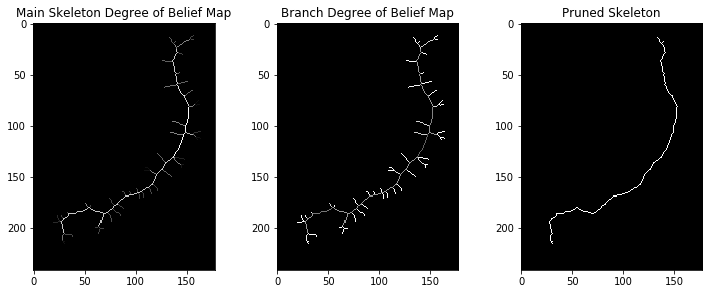

In [7]:

skeletonNew, MSDB,BDB = fuzzyTransform(fluxTemp, vertices, edgeList, edgeProperties, verticesProperties, verticesProperties2, adjacencyMatrix, returnDB=True)
f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10,30))
ax1.imshow(MSDB,cmap ='gist_gray')
ax1.set_title('Main Skeleton Degree of Belief Map')
ax2.imshow(BDB,cmap ='gist_gray')
ax2.set_title('Branch Degree of Belief Map')
ax3.imshow(skeletonNew, cmap='gray')
ax3.set_title('Pruned Skeleton')
plt.tight_layout()
plt.show()